In [1]:
import torch
from torchvision.datasets import Cityscapes
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torch.utils.data import DataLoader,Subset
from torchvision.transforms import functional as F
import torchvision.transforms as T
from tqdm import tqdm
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn

## 加载训练好的模型

In [2]:
# 配置gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from label_mapping import name2label
filterd_label=list(name2label.keys())
# 加载 Faster R-CNN结构
model = fasterrcnn_resnet50_fpn()
#修改分类头
num_classes = len(filterd_label) + 1  # 加1是因为要包括背景类，在pytorch官方定义的fasterrcnn 模型中，0是背景类别
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
model = model.to(device)
model.load_state_dict(torch.load("./fasterrcnn_cityscapes.pth"))



/tmp/ipykernel_2234679/2602500925.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./fasterrcnn_cityscapes.pth"))


<All keys matched successfully>

## 加载 Cityscapes 验证集

In [3]:

from dataset import CityscapesDataset
test_dataset = CityscapesDataset("./data/cityscapes",split="val")
# todo 只取前10条数据
test_dataset = Subset(test_dataset, list(range(10)))
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, num_workers=4,collate_fn=lambda x: tuple(zip(*x)))


## 进行推理

In [4]:
#进行推理
predictions = []
model.eval()
with torch.no_grad():
    for imgs, _ in tqdm(test_loader):
        imgs = list(img.to(device) for img in imgs)
        preds = model(imgs)  # 进行推理
        predictions.append(preds)

100%|████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.32it/s]


## 可视化检测结果

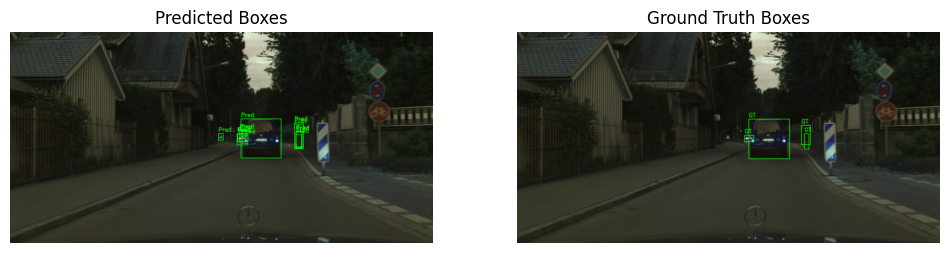

In [5]:
from utils import visualize_predictions
for i, (imgs, gts) in enumerate(test_loader):
    img = imgs[0]  # 每个batch取一张图片
    pred = predictions[i][0]  # 对应图片的预测结果
    visualize_predictions(img, pred, gts[0]["boxes"])
    break